In [1]:
import SimPEG as simpeg
from SimPEG import NSEM
from glob import glob
import numpy as np, sys, matplotlib.pyplot as plt
# sys.path.append('/home/gudni/Dropbox/Work/UBCwork/SyntheticModels/SynGeothermalStructures/ThesisModels')
# import synhelpFunc

In [2]:
def convergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    try:
        phim = np.array([res['phi_m'] for res in resList]).T
    except:
        phim = np.array([res['phi_ms'] for res in resList]).T + np.array([res['phi_mx'] for res in resList]).T + np.array([res['phi_my'] for res in resList]).T + np.array([res['phi_mz'] for res in resList]).T     
    
    x = np.arange(len(its))
    
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--')
    ax1.set_ylabel('phi_d', color='b')
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax2 = ax1.twinx()          
    ax2.semilogy(x,phim[ind],'rx--',)
    ax2.set_ylabel('phi_m', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.show()
    
def tikanovCurve(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.loglog(phim[ind],phid[ind],'bx--')
    ax1.set_ylabel('phi_d')
    ax1.set_xlabel('phi_m')
    plt.hlines(len(resList[0]['dpred'])*.75,np.min(phim),np.max(phim),colors='g',linestyles='-.')
    plt.show()
    
def allconvergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    phims = np.array([res['phi_ms'] for res in resList]).T
    phimx = np.array([res['phi_mx'] for res in resList]).T
    phimy = np.array([res['phi_my'] for res in resList]).T
    phimz = np.array([res['phi_mz'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--',label='phid')
    ax1.set_ylabel('phi_d', color='b')
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')         
    ax1.semilogy(x,phim[ind],'gx--',label='phim')
    ax1.semilogy(x,phims[ind],'y,--',label='phims')
    ax1.semilogy(x,phimx[ind],'r.--',label='phimx')
    ax1.semilogy(x,phimy[ind],'r+--',label='phimy')
    ax1.semilogy(x,phimz[ind],'r*--',label='phimz')
    
    plt.legend()
    plt.show()

def loadInversionMakeVTRFiles(dirStr,mesh,mapping):
    temp = [np.load(f) for f in glob(dirStr+'/*Inversion*.npz')]
    iterResults = [i if len(i.keys()) > 1 else i['arr_0'].tolist() for i in temp ]
    # Make the vtk models
    for it in iterResults:
        mesh.writeVTK(dirStr+'/recoveredMod_{:s}_it{:.0f}.vtr'.format(dirStr,int(it['iter'])),{'S/m':mapping*it['m']})
    return iterResults

In [3]:
# Load the model
mesh, modDict = simpeg.Mesh.TensorMesh.readVTK('nsmesh_GKRCoarseHKPK1.vtr')
sigma = modDict['S/m']

In [4]:
# Make the mapping
active = sigma != 1e-8
actMap = simpeg.Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nC)
mappingExpAct = simpeg.Maps.ExpMap(mesh) * actMap

In [5]:
# Load the data
drecAll = np.load('MTdataStArr_nsmesh_GKRHKPK1.npy')


### run1


In [7]:
# Select larger frequency band for the MT data
indMTFreq1 = np.sum( [drecAll['freq'] == val for val in  np.unique(drecAll['freq'])[12::2]] ,axis=0,dtype=bool)
mtRecArr1 = drecAll[indMTFreq1][['freq','x','y','z','zxy','zyx']]
dUse1 = NSEM.Data.fromRecArray(mtRecArr1)

# Extract to survey
survey1 = dUse1.survey

In [62]:
run1Files = loadInversionMakeVTRFiles('run1',mesh,mappingExpAct)

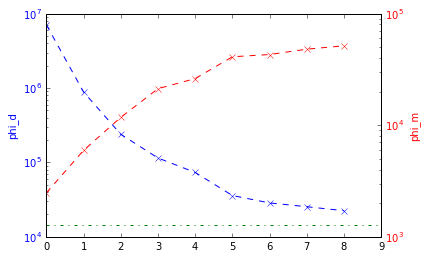

In [63]:
%matplotlib inline
convergeCurves(run1Files)

In [64]:
[res['iter'] for res in run1Files]

[3, 1, 8, 7, 5, 2, 4, 6, 9]

In [76]:
%matplotlib qt
sys.path.append('/home/gudni/Dropbox/code/python/MTview/')
import interactivePlotFunctions as iPf

In [77]:
finData1 = NSEM.Data(survey1,run1Files[np.argmax([it['iter'] for it in run1Files])]['dpred']).toRecArray('Complex')

In [78]:
%matplotlib qt
iPf.MTinteractiveMap([dUse1.toRecArray('Complex'),finData1])

### run2

In [42]:
indMTFreq2 = np.sum( [drecAll['freq'] == val for val in  np.unique(drecAll['freq'])[12::2]] ,axis=0,dtype=bool)
mtRecArr2 = drecAll[indMTFreq2][['freq','x','y','z','zxx','zxy','zyx','zyy']]
dUse2 = NSEM.Data.fromRecArray(mtRecArr2)

# Extract to survey
survey2 = dUse2.survey

In [72]:
run2Files = loadInversionMakeVTRFiles('run2',mesh,mappingExpAct)

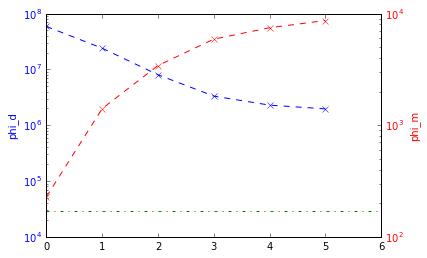

In [73]:
%matplotlib inline
convergeCurves(run2Files)

In [45]:
finData2 = NSEM.Data(survey2,run2Files[np.argmax([it['iter'] for it in run2Files])]['dpred']).toRecArray('Complex')

In [47]:
%matplotlib qt
iPf.MTinteractiveMap([dUse2.toRecArray('Complex'),finData2])

In [74]:
np.sum(mesh.hx)

31787.095499038696

In [75]:
NSEM.Utils.skindepth(10000,10)

15915.494309189533